# FORCE Learning

In [ ]:
!pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.8-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax

ERROR: jaxlib-0.1.8-cp36-none-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 686kB 4.0MB/s 


### Import some packages

In [ ]:
from jax import random

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras import backend, activations
 
print(tf.__version__)

2.5.0


**Lorentz Attractor**

In [ ]:
T = 39            # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 1000            # size of the reservoir in the ESN
tau = 0.1           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later
 
g = 1.5  # Lower g value was shown to be good in the paper for training.
m = 1
alpha = 1e0 # Initial learning rate for RLS
dtdivtau = dt / tau

input1 = tf.expand_dims(x_t,0)

In [ ]:
# Generate randomness

def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [ ]:
def random_esn_params(key, u, n, m, tau=1.0, dt=0.1, g=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: dim of the hidden state
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """

  key, skeys = keygen(key, 5)
  hscale = 0.25
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  return {'a0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) * hfactor,
          'wO' : random.normal(next(skeys), (m,n)) * pfactor,
          'wF' : random.normal(next(skeys), (n,m)) * ffactor,
          'dt_over_tau' : dt / tau}

In [ ]:
# params_seed = np.random.randint(0, 10000000)
# print("Params seed %d" %(params_seed))
# key = random.PRNGKey(params_seed)
# init_params = random_esn_params(key, u, n, m, g=g)

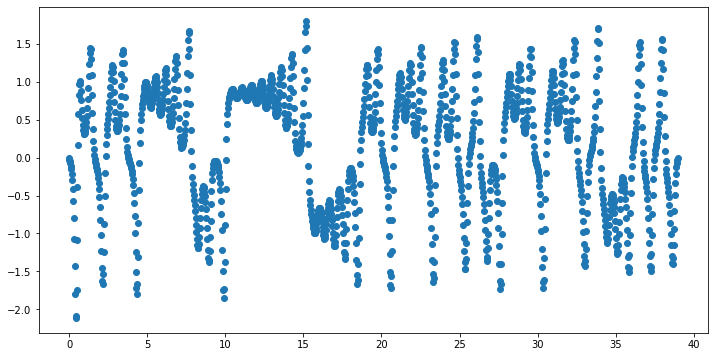

In [ ]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


num_steps = ntime

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0,-1,0.25)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

f_t_1 = (tf.expand_dims(tf.convert_to_tensor(np.float32(xs[:ntime])), axis = 1)/10)[::3] #(xs**2+ys**2+zs**2)**0.5
#f_t_1 = (tf.expand_dims(tf.convert_to_tensor(np.float32(f_t_1[:ntime])),axis = 1)/100)[::10]
input1 = input1[0,::3]
time = time[::3]
plt.figure(figsize = (12,6))
plt.scatter(time, f_t_1)

In [ ]:
# wI = tf.transpose(tf.convert_to_tensor(init_params['wI']))
# wR = tf.transpose(tf.convert_to_tensor(init_params['wR']))
# wF = tf.transpose(tf.convert_to_tensor(init_params['wF']))
# wO = tf.transpose(tf.convert_to_tensor(init_params['wO']))
# a0 = np.arctanh(np.linalg.pinv(wO.numpy()))*f_t_1[0]

In [ ]:
class FORCELayer(keras.layers.AbstractRNNCell):
    def __init__(self, units, output_size, activation, seed = None, g = 1.5, 
                 input_kernel_trainable = False, recurrent_kernel_trainable = False, 
                 output_kernel_trainable = True, feedback_kernel_trainable = False, **kwargs):
      
        self.units = units 
        self.__output_size__ = output_size
        self.activation = activations.get(activation)

        if seed is None:
          self.__seed_gen__ = tf.random.Generator.from_non_deterministic_state()
        else:
          self.__seed_gen__ = tf.random.Generator.from_seed(seed)
        
        self.__g__ = g

        self.__input_kernel_trainable__ = input_kernel_trainable
        self.__recurrent_kernel_trainable__ = recurrent_kernel_trainable
        self.__feedback_kernel_trainable__ = feedback_kernel_trainable
        self.__output_kernel_trainable__ = output_kernel_trainable

        super().__init__(**kwargs)

    @property
    def state_size(self):
        return [self.units, self.units, self.output_size]

    @property 
    def output_size(self):
        return self.__output_size__

    def build(self, input_shape):

        self.input_kernel = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/input_shape[-1]**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]),
          trainable=self.__input_kernel_trainable__,
          name='input_kernel')
 
        self.recurrent_kernel = self.add_weight(
          shape=(self.units, self.units),
          initializer= keras.initializers.RandomNormal(mean=0., 
                                                       stddev= self.__g__/self.units**0.5, 
                                                       seed=self.__seed_gen__.uniform([1], 
                                                                                  minval=None, 
                                                                                  dtype=tf.dtypes.int64)[0]), 
          trainable=self.__recurrent_kernel_trainable__,
          name='recurrent_kernel')
        
        self.feedback_kernel = self.add_weight(
          shape=(self.output_size, self.units), 
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]), 
          trainable=self.__feedback_kernel_trainable__,
          name='feedback_kernel')
        
        self.output_kernel = self.add_weight(
          shape=(self.units, self.output_size),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/self.units**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]), 
          trainable=self.__output_kernel_trainable__,
          name='output_kernel')      

        self.built = True

    @classmethod
    def from_weights(cls, weights, **kwargs):
        # Initialize the network from a list of weights (e.g., user-generated)
        input_kernel, recurrent_kernel, feedback_kernel, output_kernel = weights 
        input_shape, input_units = input_kernel.shape 
        recurrent_units1, recurrent_units2 = recurrent_kernel.shape 
        feedback_output_size, feedback_units = feedback_kernel.shape 
        output_units, output_size = output_kernel.shape 


        units = input_units 
        assert np.all(np.array([input_units, recurrent_units1, recurrent_units2, 
                            feedback_units, output_units]) == units)

        assert feedback_output_size == output_size 

        self = cls(units=units, output_size=output_size, **kwargs)

        self.input_kernel = self.add_weight(shape=(input_shape, self.units),
                                      initializer=keras.initializers.constant(input_kernel),
                                      trainable = self.__input_kernel_trainable__,
                                      name='input_kernel')
        
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer=keras.initializers.constant(recurrent_kernel),
            trainable = self.__recurrent_kernel_trainable__,
            name='recurrent_kernel')
        
        self.feedback_kernel = self.add_weight(
            shape=(self.output_size, self.units),
            initializer=keras.initializers.constant(feedback_kernel),
            trainable = self.__feedback_kernel_trainable__,
            name='feedback_kernel')
        
        self.output_kernel = self.add_weight(
            shape=(self.units, self.output_size),
            initializer=keras.initializers.constant(output_kernel),
            trainable = self.__output_kernel_trainable__,
            name='output_kernel')      

        self.built = True

        return self

class FORCEModel(keras.Model):
    def __init__(self, force_layer, alpha_P=1.,return_sequences=True):
        super().__init__()
        self.alpha_P = alpha_P
        self.force_layer = keras.layers.RNN(force_layer, 
                                            stateful=True, 
                                            return_state=True, 
                                            return_sequences=return_sequences)

        self.units = force_layer.units 

        self.__force_layer__ = force_layer
 

    def build(self, input_shape):
        self.P_output = self.add_weight(name='P_output', shape=(self.units, self.units), 
                                 initializer=keras.initializers.Identity(
                                              gain=self.alpha_P), trainable=True)
        
        super().build(input_shape)


    def call(self, x, training=False,   **kwargs):

        if training:
            return self.force_layer(x, **kwargs) 
        else:
            initialization = all(v is None for v in self.force_layer.states)
            
            if not initialization:
              original_state = [i.numpy() for i in self.force_layer.states]
            output = self.force_layer(x, **kwargs)[0] 

            if not initialization:
              self.force_layer.reset_states(states = original_state)
            return output

    def train_step(self, data):

        x, y = data

        if self.run_eagerly:
          self.hidden_activation = []
        
        for i in range(x.shape[1]):
          z, _, h, _ = self(x[:,i:i+1,:], training=True)

          if self.force_layer.return_sequences:
            z = z[:,0,:]

          # Compute pseudogradients
          trainable_vars = self.trainable_variables
          for idx in range(len(trainable_vars)):
            if 'output_kernel' in trainable_vars[idx].name:
              output_kernel_idx = idx
            elif 'P_output' in trainable_vars[idx].name:
              P_output_idx = idx

          dP = self.__pseudogradient_P(h, z, y[:,i,:])
          # Update weights
          self.optimizer.apply_gradients(zip([dP], [trainable_vars[P_output_idx]]))
          
          dwO = self.__pseudogradient_wO(h, z, y[:,i,:])
          self.optimizer.apply_gradients(zip([dwO], [trainable_vars[output_kernel_idx]]))

        # Update metrics (includes the metric that tracks the loss)
          self.compiled_metrics.update_state(y[:,i,:], z)
        # Return a dict mapping metric names to current value

          if self.run_eagerly:
            self.hidden_activation.append(h.numpy()[0])

        return {m.name: m.result() for m in self.metrics}

    def __pseudogradient_P(self, h, z, y):
        # Implements the training step i.e. the rls() function
        # This not a real gradient (does not use gradient.tape())
        # Computes the actual update
        # Example array shapes
        # h : 1 x 500
        # P : 500 x 500 
        # k : 500 x 1 
        # hPht : 1 x 1
        # dP : 500 x 500 


        k = backend.dot(self.P_output, tf.transpose(h))
        hPht = backend.dot(h, k)
        c = 1./(1.+hPht)
        assert c.shape == (1,1)
        hP = backend.dot(h, self.P_output)
        dP = backend.dot(c*k, hP)
        
        return  dP 

    def __pseudogradient_wO(self, h, z, y):
        # z : 1 x 20 
        # y : 1 x 20
        # e : 1 x 20
        # dwO : 500 x 20  

        e = z-y
        Ph = backend.dot(self.P_output, tf.transpose(h))
        dwO = backend.dot(Ph, e)

        return  dwO

    def compile(self, metrics, **kwargs):
        super().compile(optimizer=keras.optimizers.SGD(learning_rate=1), loss = 'mae', metrics=metrics,   **kwargs)

    def fit(self, x, y=None, epochs = 1, verbose = 'auto', **kwargs):

        if len(x.shape) < 2 or len(x.shape) > 3:
            raise ValueError('Shape of x is invalid')

        if len(y.shape) < 2 or len(y.shape) > 3:
            raise ValueError('Shape of y is invalid')
        
        if len(x.shape) == 2:
            x = tf.expand_dims(x, axis = 0)
        
        if len(y.shape) == 2:
            y = tf.expand_dims(y, axis = 0)
        
        if x.shape[0] != 1:
            raise ValueError("Dim 0 of x must be 1")

        if y.shape[0] != 1:
            raise ValueError("Dim 0 of y must be 1")
        
        if x.shape[1] != y.shape[1]: 
            raise ValueError('Timestep dimension of inputs must match')     

        return super().fit(x = x, y = y, epochs = epochs, batch_size = 1, verbose = verbose, **kwargs)

    def predict(self, x, **kwargs):
        if len(x.shape) == 3 and x.shape[0] != 1:
            raise ValueError('Dim 0 must be 1')
        
        if len(x.shape) < 2 or len(x.shape) > 3:
            raise ValueError('')

        if len(x.shape) == 2:
            x = tf.expand_dims(x, axis = 0)

        return self(x, training = False)[0]

In [ ]:
class EchoStateNetwork(FORCELayer):
    def __init__(self, dtdivtau, hscale = 0.25, initial_a = None, **kwargs):
        self.dtdivtau = dtdivtau 
        self.hscale = hscale
        self.__initial_a__ = initial_a
        super().__init__(**kwargs)        

    def call(self, inputs, states):
        """Implements the forward step (i.e., the esn() function)
        """
        prev_a, prev_h, prev_output = states      
        input_term = backend.dot(inputs, self.input_kernel)
        recurrent_term = backend.dot(prev_h, self.recurrent_kernel)
        feedback_term = backend.dot(prev_output, self.feedback_kernel)

        dadt = -prev_a + input_term + recurrent_term + feedback_term 
        a = prev_a + self.dtdivtau * dadt
        h = self.activation(a)
        output = backend.dot(h, self.output_kernel)

        return output, [a, h, output]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):

        if self.__initial_a__ is not None:
          init_a = self.__initial_a__
        else:
          initializer = keras.initializers.RandomNormal(mean=0., 
                                                        stddev= self.hscale , 
                                                        seed = self.__seed_gen__.uniform([1], 
                                                                                        minval=None, 
                                                                                        dtype=tf.dtypes.int64)[0])
          init_a = initializer((batch_size, self.units))  

        init_h =  self.activation(init_a)
        init_out = backend.dot(init_h,self.output_kernel) 

        return (init_a, init_h, init_out)

In [ ]:
# Original
# class EarlyStoppingByLossVal(keras.callbacks.Callback):
#     def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
#         super().__init__()
#         self.monitor = monitor
#         self.value = value
#         self.verbose = verbose

#     def on_epoch_end(self, epoch, logs={}):
#         current = logs.get(self.monitor)
#         if current is None:
#             warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

#         if current < self.value:
#             if self.verbose > 0:
#                 print("Epoch %05d: early stopping THR" % epoch)
#             self.model.stop_training = True

In [ ]:
class EarlyStoppingByVal(keras.callbacks.Callback):
    def __init__(self, monitor='mae', thresh = 0.00001, value=0.00001, total_epoch = 7, verbose=0):
        super().__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.tracking = []
        self.total = 0
        self.total_epoch = total_epoch
        self.thresh = thresh

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)

        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
        
        temp = (current < self.value)
        self.tracking.append(temp)
        self.total += temp

        if len(self.tracking) > self.total_epoch:
          self.total -= self.tracking.pop(0)
        
        if self.total == self.total_epoch and current < self.thresh:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [ ]:
myesn = EchoStateNetwork( dtdivtau= dtdivtau, units = n, 
                          output_size = m, activation = 'tanh')

# myesn = EchoStateNetwork.from_weights(dtdivtau=dtdivtau, 
#                                       initial_a = a0,
#                                       weights = (wI, wR, wF, wO), 
#                                       activation = 'tanh' )

model = FORCEModel(myesn, return_sequences=True)  
model.compile(metrics=["mae"], run_eagerly = False)
 
early_stopping = EarlyStoppingByVal(monitor='mae', thresh = 0.01, value=0.02, total_epoch = 500, verbose=1)
model_chkpt = keras.callbacks.ModelCheckpoint(
    'saved_model.h5',
    monitor='mae',
    mode='min',
    verbose = 1,
    save_weights_only = True, 
    save_best_only=True)


In [ ]:
history = model.fit(x=input1 , y= f_t_1, epochs = 2000, callbacks=[early_stopping]) #callbacks=[early_stopping, model_chkpt])

Epoch 1/2000
1/1 [==============================] - 525s 525s/step - mae: 0.0906
Epoch 2/2000
1/1 [==============================] - 3s 3s/step - mae: 0.0971
Epoch 3/2000
1/1 [==============================] - 4s 4s/step - mae: 0.1112
Epoch 4/2000
1/1 [==============================] - 4s 4s/step - mae: 0.1052
Epoch 5/2000
1/1 [==============================] - 4s 4s/step - mae: 0.0929
Epoch 6/2000
1/1 [==============================] - 4s 4s/step - mae: 0.0898
Epoch 7/2000
1/1 [==============================] - 3s 3s/step - mae: 0.0876
Epoch 8/2000
1/1 [==============================] - 3s 3s/step - mae: 0.0770
Epoch 9/2000
1/1 [==============================] - 4s 4s/step - mae: 0.0804
Epoch 10/2000
1/1 [==============================] - 4s 4s/step - mae: 0.0633
Epoch 11/2000
1/1 [==============================] - 3s 3s/step - mae: 0.0573
Epoch 12/2000
1/1 [==============================] - 4s 4s/step - mae: 0.0558
Epoch 13/2000
1/1 [==============================] - 4s 4s/step - mae

In [ ]:
#model.load_weights('/content/saved_model.h5')

In [ ]:
z_t_call = model.predict(input1)

In [ ]:
np.mean(np.abs(z_t_call - f_t_1))

0.0035742132

Text(0, 0.5, 'Dimension')

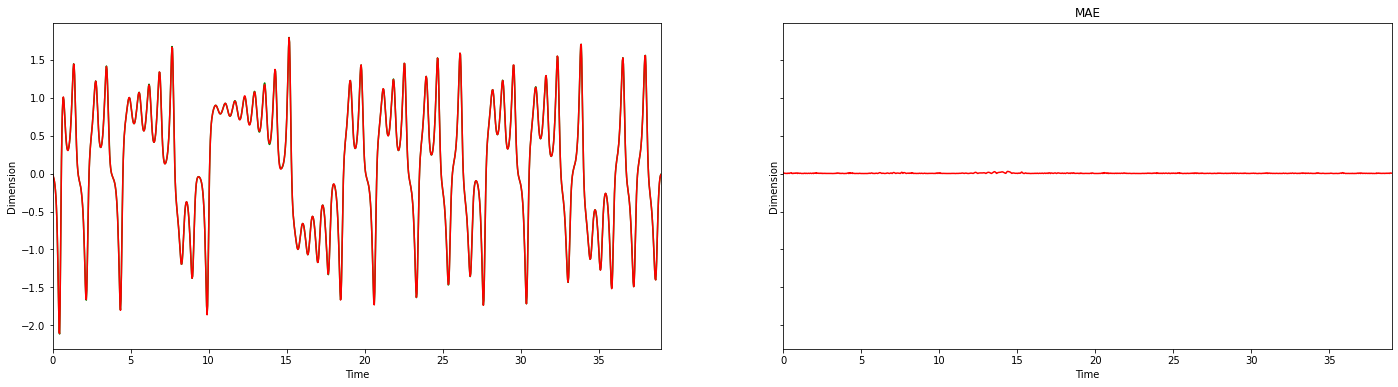

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(24,6))


ax1.plot(time , f_t_1  + 2*np.arange(0, f_t_1.shape[1]), 'g')
ax1.plot(time , z_t_call + 2*np.arange(0, z_t_call.shape[1]), 'r');
 
ax1.set_xlim((0, T))
plt.title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

ax2.plot(time, tf.math.abs(f_t_1-z_t_call) + 2*np.arange(0, z_t_call.shape[1]), 'r');
ax2.set_xlim((0, T))
plt.title('MAE')
ax2.set_xlabel('Time')
ax2.set_ylabel('Dimension')

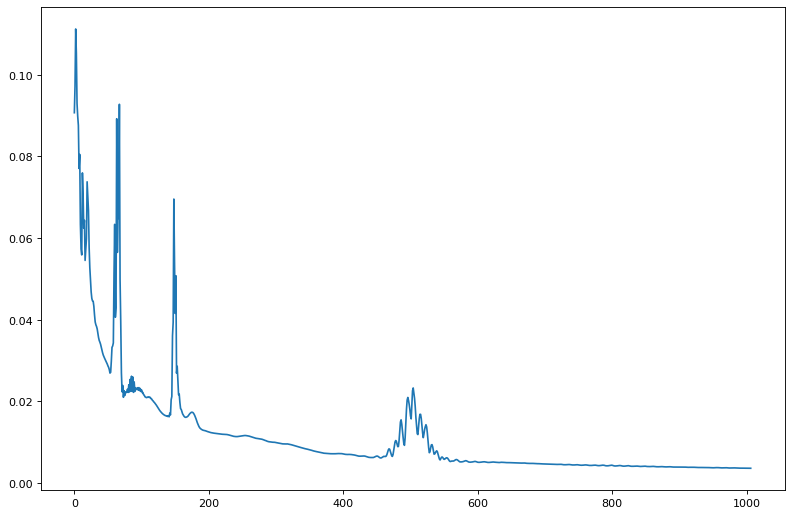

In [ ]:
plt.figure(figsize=(12,8), dpi=80)
plt.plot(history.history['mae'])

In [ ]:
del model
del myesn

In [ ]:
import gc
gc.collect()

903

**Square Wave**

In [ ]:
T = .6              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)  
n = 2500             # size of the reservoir in the ESN
tau = 0.015          # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later
 
g = 1.5  # Lower g value was shown to be good in the paper for training.
m = 1
alpha = 1e0 # Initial learning rate for RLS
dtdivtau = dt / tau

input1 = tf.expand_dims(x_t,0)

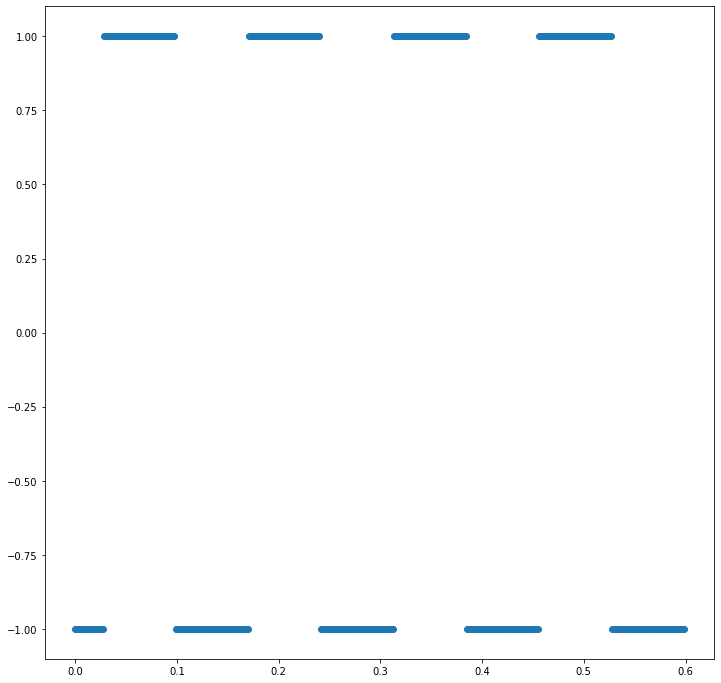

In [ ]:
from scipy import signal
f_t_1 = tf.expand_dims(np.float32(signal.square(2 * np.pi* 7*time)),axis = 1)[::-1]*-1

plt.figure(figsize = (12,12))
plt.scatter(time,f_t_1)

In [ ]:
myesn = EchoStateNetwork( dtdivtau= dtdivtau, units = n, output_size = m, activation = 'tanh')
model = FORCEModel(myesn, return_sequences=True)  
model.compile(metrics=["mae"])

In [ ]:
history = model.fit(x=input1 , y= f_t_1, epochs = 1000)

Epoch 1/1000
1/1 [==============================] - 8s 8s/step - mae: 0.1689
Epoch 2/1000
1/1 [==============================] - 8s 8s/step - mae: 0.1180
Epoch 3/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0972
Epoch 4/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0740
Epoch 5/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0724
Epoch 6/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0738
Epoch 7/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0797
Epoch 8/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0739
Epoch 9/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0701
Epoch 10/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0708
Epoch 11/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0748
Epoch 12/1000
1/1 [==============================] - 8s 8s/step - mae: 0.0698
Epoch 13/1000
1/1 [==============================] - 8s 8s/step - mae: 0.

In [ ]:
z_t_call = model.predict(input1)

In [ ]:
np.mean(np.abs(f_t_1-z_t_call))

0.047592845

Text(0, 0.5, 'Dimension')

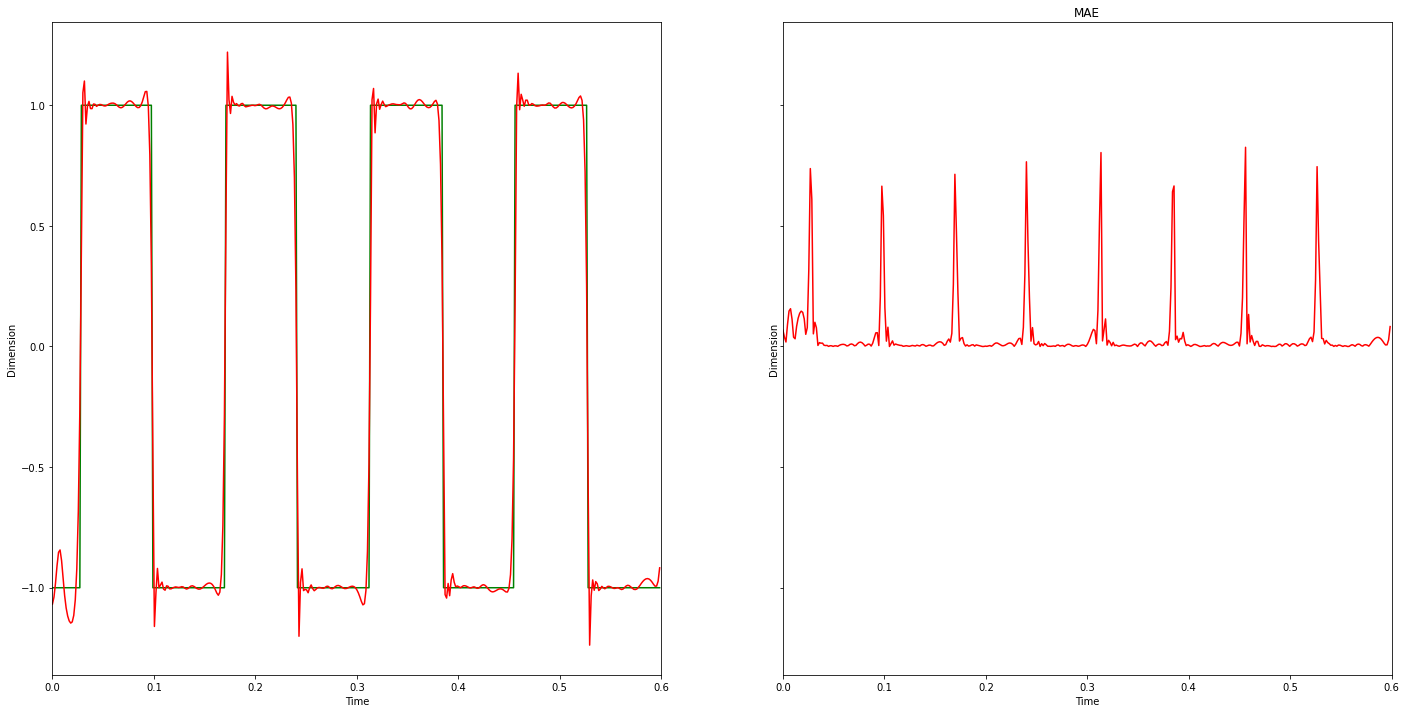

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(24,12))


ax1.plot(time , f_t_1  + 2*np.arange(0, f_t_1.shape[1]), 'g')
ax1.plot(time , z_t_call + 2*np.arange(0, z_t_call.shape[1]), 'r');
 
ax1.set_xlim((0, T))
plt.title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

ax2.plot(time, tf.math.abs(f_t_1-z_t_call) + 2*np.arange(0, z_t_call.shape[1]), 'r');
ax2.set_xlim((0, T))
plt.title('MAE')
ax2.set_xlabel('Time')
ax2.set_ylabel('Dimension')

In [ ]:
model.__force_layer__.recurrent_kernel.trainable

False

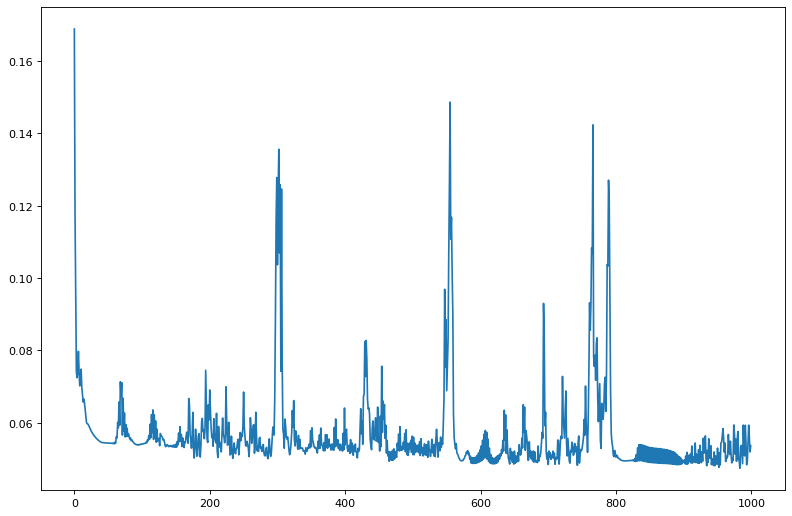

In [ ]:
plt.figure(figsize=(12,8), dpi=80)
plt.plot(history.history['mae'])